In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy.io import wavfile
from scipy.signal import correlate
from scipy.fft import ifft, fft, fftfreq, fftshift, ifft2, fft2
from methods import load_file, load_dataframe, plot_signal, cut_signal, plot_cut, corr_f, split_array, mean_corr

**Читаем все файлы в массивы:**

In [2]:
paths = ['Клязьма 17.09.24 вертикаль/Track1/receivers/TASCAM_0019S1.wav', 'Клязьма 17.09.24 вертикаль/Track1/receivers/TASCAM_0019S2.wav', 'Клязьма 17.09.24 вертикаль/Track1/source/TASCAM_0054S4.wav',
         'Клязьма 17.09.24 вертикаль/Track2/receivers/TASCAM_0020S1.wav', 'Клязьма 17.09.24 вертикаль/Track2/receivers/TASCAM_0020S2.wav', 'Клязьма 17.09.24 вертикаль/Track2/source/TASCAM_0055S4.wav']
names = ['Track 1 Receiver 1', 'Track 2 Receiver 2', 'Track 1 Source',
         'Track 2 Receiver 1', 'Track 2 Receiver 2', 'Track 2 Source']
dct = {'name': [], 'sample_rate': [], 'data': [], 'time': []}

df = load_dataframe(paths=paths, names=names, dct=dct)

**Отрисовываем все сигналы для последующей обрезки:**

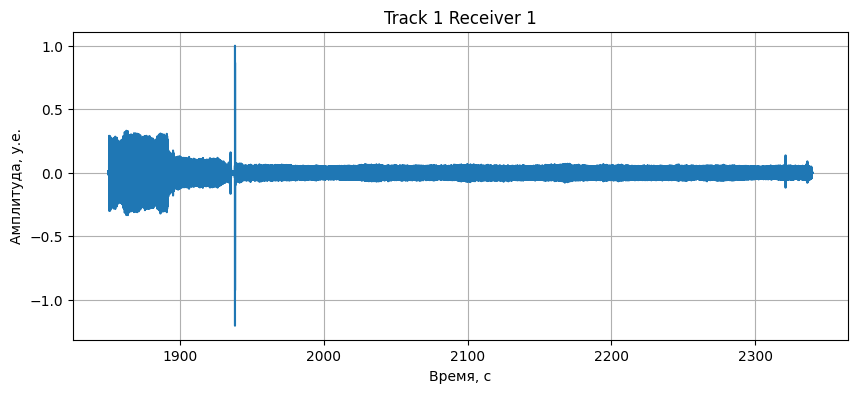

Максимум по амплитуде: 1.0
Время максимума: 1938.2245351473923 с.


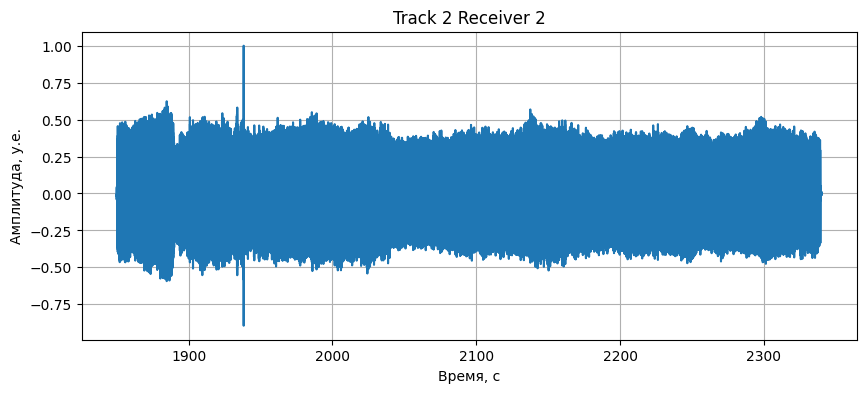

Максимум по амплитуде: 1.0
Время максимума: 1938.2720408163266 с.


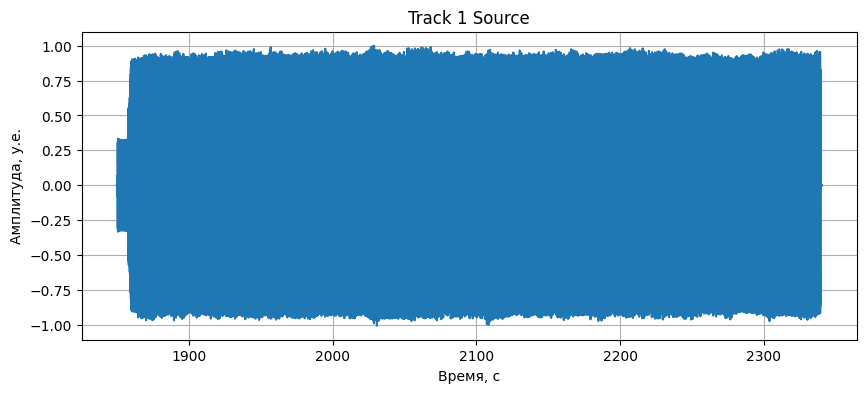

Максимум по амплитуде: 1.0
Время максимума: 2028.8692063492063 с.


In [3]:
df_cut = plot_cut(borders=[1850.0, 2340.0], number=3, df=df)

**Построим корреляцию:**

**Много маленьких и усреднить + все сразу выводить. Много корреляций по 1/30 с и идем по времени. А потом усредняем. Еще вариант брать abs и складывать**

In [20]:
final_corr = mean_corr(df=df_cut, pair=[1,3], n=1324)

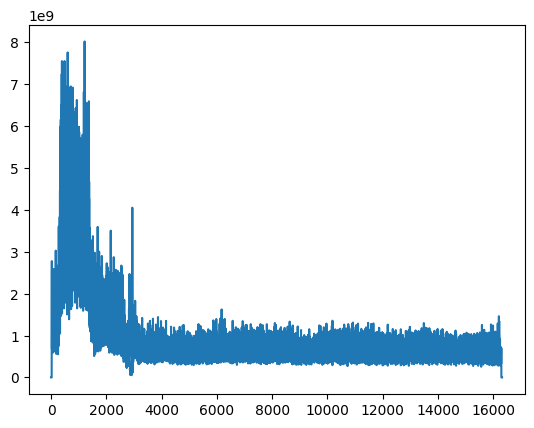

In [21]:
plt.plot(final_corr)

In [4]:
corr, lags = corr_f(df_cut['data'][0], df_cut['data'][1], sample_rate=44100, filter_freq=200, do_filter=False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


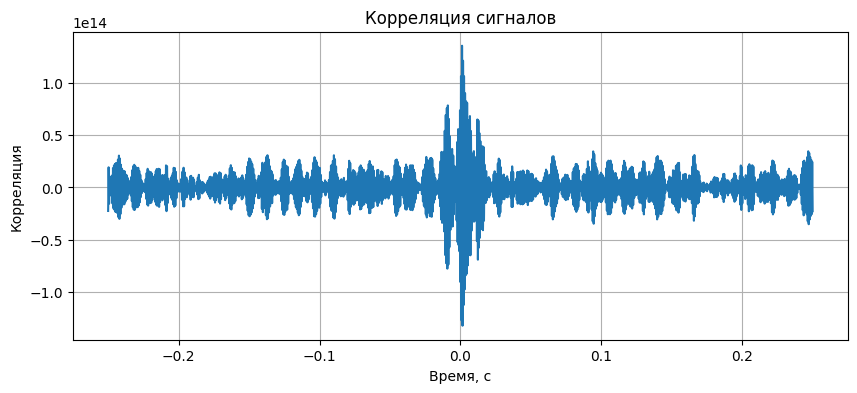

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(lags, corr)
plt.title('Корреляция сигналов')
plt.xlabel('Время, c')
plt.ylabel('Корреляция')
plt.grid(True)
plt.show()